In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('datasets/language_names/names/*.txt'))


['datasets/language_names/names\\Arabic.txt', 'datasets/language_names/names\\Chinese.txt', 'datasets/language_names/names\\Czech.txt', 'datasets/language_names/names\\Dutch.txt', 'datasets/language_names/names\\English.txt', 'datasets/language_names/names\\French.txt', 'datasets/language_names/names\\German.txt', 'datasets/language_names/names\\Greek.txt', 'datasets/language_names/names\\Irish.txt', 'datasets/language_names/names\\Italian.txt', 'datasets/language_names/names\\Japanese.txt', 'datasets/language_names/names\\Korean.txt', 'datasets/language_names/names\\Polish.txt', 'datasets/language_names/names\\Portuguese.txt', 'datasets/language_names/names\\Russian.txt', 'datasets/language_names/names\\Scottish.txt', 'datasets/language_names/names\\Spanish.txt', 'datasets/language_names/names\\Vietnamese.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('datasets/language_names/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Slusarski


In [3]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [21]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_size)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(1, 1, -1))
        output = self.hidden2output(lstm_out.view(1, -1))
        output = self.softmax(output)
        return output

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [23]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output = rnn(input)

In [24]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output = rnn(input[0])
print(output)

tensor([[-2.9238, -2.9436, -2.8672, -2.8314, -2.7951, -2.9254, -2.8880, -2.9081,
         -2.9203, -2.8625, -2.9311, -2.9362, -2.8890, -2.8571, -2.9118, -2.8043,
         -2.8999, -2.9502]], grad_fn=<LogSoftmaxBackward>)


In [25]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 4)


In [26]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Alves
category = French / line = Lavigne
category = Scottish / line = Johnston
category = Polish / line = Mencher
category = Arabic / line = Bazzi
category = Portuguese / line = Abreu
category = Irish / line = O'Grady
category = Scottish / line = Mackay
category = Vietnamese / line = An
category = German / line = Krauss


In [27]:
criterion = nn.NLLLoss()

In [28]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    # hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output = rnn(line_tensor[i])

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 25s) 2.8689 Vinny / Japanese ✗ (English)
10000 10% (0m 52s) 2.8337 Gensai / Russian ✗ (Japanese)
15000 15% (1m 18s) 2.8377 Silveira / Japanese ✗ (Portuguese)
20000 20% (1m 45s) 2.7898 Darakov / Russian ✓
25000 25% (2m 10s) 2.7071 Mazaki / Italian ✗ (Japanese)
30000 30% (2m 36s) 2.8595 O'Dowd / Scottish ✗ (Irish)
35000 35% (3m 2s) 2.3529 Taguchi / Japanese ✓
40000 40% (3m 29s) 2.6449 Wang / Chinese ✗ (Korean)
45000 45% (3m 55s) 2.4550 O'Leary / Irish ✓
50000 50% (4m 17s) 2.1208 Iturburua / Japanese ✗ (Spanish)
55000 55% (4m 34s) 1.4518 Albini / Italian ✓
60000 60% (4m 51s) 2.6197 Shi / Italian ✗ (Chinese)
65000 65% (5m 8s) 2.0268 Henderson / Irish ✗ (Scottish)
70000 70% (5m 24s) 2.0504 Mcmillan / Irish ✗ (Scottish)
75000 75% (5m 41s) 2.1980 Takemago / Italian ✗ (Japanese)
80000 80% (5m 59s) 2.1248 Fumihiko / Italian ✗ (Japanese)
85000 85% (6m 15s) 1.9163 Alves / Greek ✗ (Portuguese)
90000 90% (6m 33s) 3.6457 Abascal / Czech ✗ (Spanish)
95000 95% (6m 50s) 1.6485 Rosario / Por

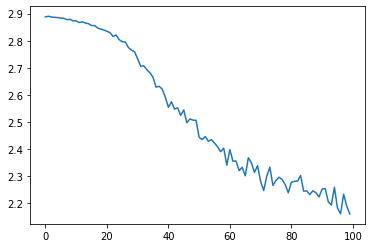

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

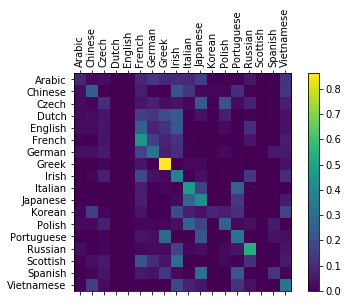

In [34]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output = rnn(line_tensor[i])

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [35]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.80) Russian
(-2.09) Irish
(-2.17) Scottish

> Jackson
(-1.95) Irish
(-2.12) Scottish
(-2.35) Chinese

> Satoshi
(-1.30) Italian
(-1.57) Japanese
(-1.60) Polish
